Text(0, 0.5, 'Activity')

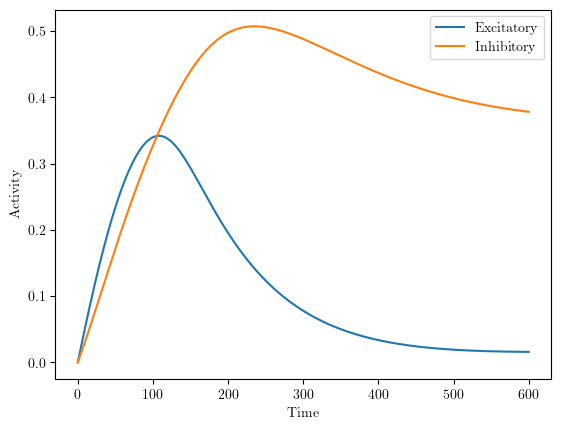

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('animation', html='jshtml')

%matplotlib inline

# constants
r = .2
tau_E = 1.
tau_I = 2.

P = 0.2
Q = .5

w_ee = 10
w_ei = 12
w_ie = 9
w_ii = 3

def sig(x):
    return 1/(1 + np.exp(-x))

def tanh(x):
    return 2*sig(2*x) - 1

def dedt(t, E, I, P):
    de = (-E + (1 - r*E)*sig(w_ee*E - w_ei*I + P)) / tau_E
    # de = (-E + sig(k*E + k*P)) / tau_E
    return de

def didt(t, E, I, Q):
    di = (-I + (1 - r*I)*sig(w_ie*E - w_ii*I + Q)) / tau_I
    return np.array([di])

T = 6
dt = .01
t = np.arange(0, T + dt, dt)
E = np.zeros(len(t))
I = np.zeros(len(t))

for i in range(len(t) - 1):
    E[i + 1] = E[i] + dt * dedt(t[i], E[i], I[i], P)
    I[i + 1] = I[i] + dt * didt(t[i], E[i], I[i], Q)

# E += np.random.normal(0, 0.01, E.shape)
plt.plot(E, label='Excitatory')
plt.plot(I, label='Inhibitory')
# plt.plot(I, label='Inhibitory')
plt.legend()

# np.save('E_synthetic_kdot5_Pdot2.npy', E)
plt.xlabel('Time')
plt.ylabel('Activity')
# plt.savefig('varying_k.pdf', dpi=600)

In [71]:
from fg.gaussian import Gaussian
import torch

g1 = Gaussian(torch.tensor([[0.]]), torch.tensor([[1.]]))
g2 = Gaussian(torch.tensor([[3.]]), torch.tensor([[5.]])) 

g1 *= g2

print(g1)

[eta=tensor([[3.]]), lambda=tensor([[6.]])]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import norm

N    = 200
X    = np.linspace(-4, 4, N)
Y    = np.linspace(-4, 4, N)
X, Y = np.meshgrid(X, Y)
pos  = np.dstack((X, Y))


def gauss2d(mean_a, mean_b, cov_aa, cov_bb):
    rv = multivariate_normal([mean_a, mean_b], [[cov_aa, 0.8], [0.8, cov_bb]])
    Z = rv.pdf(pos)
    plt.contour(X, Y, Z)
    plt.show()

def gauss1d(mean, std):
    X = np.linspace(-4, 4, N)
    z = norm.pdf(X, mean, std)
    plt.plot(X, z)
    plt.show()
    
# interact(gauss2d, mean_a = widgets.FloatSlider(value=0, min=0.1, max=5, step=0.1),
#     mean_b = widgets.FloatSlider(value=0, min=0.1, max=5, step=0.1),
#     cov_aa = widgets.FloatSlider(value=1, min=0.1, max=5, step=0.1),
#     cov_bb = widgets.FloatSlider(value=2, min=0.1, max=5, step=0.1))

interact(gauss1d, mean = widgets.FloatSlider(value = 0, min = 0, max = 5, step=0.1), std = widgets.FloatSlider(value = 0, min = .1, max = 3, step = 0.1))

In [ ]:
Et_slider = widgets.FloatSlider(value = 0, min = -5, max = 5, step=0.1)

def gauss1d_neuronal(Et, std):
    X = np.linspace(-4, 4, N)
    mean = Et + dt*dedt(0, Et, I=0, P=.2)
    print(Et, mean)
    z = norm.pdf(X, mean, std)
    plt.plot(X, z)
    plt.show()

def gauss2d_neuronal(mean_a, mean_b, cov_aa, cov_bb):
    rv = multivariate_normal([mean_a, mean_b], [[cov_aa, 0.8], [0.8, cov_bb]])
    Z = rv.pdf(pos)
    plt.contour(X, Y, Z)
    plt.show()

interact(gauss1d_neuronal, Et = Et_slider, std = 0.5)

In [ ]:
# import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets

P = .2
sigma_n = 0.05
k = 5
tau_E = 1

def sig(x):
    return 1/(1 + np.exp(-x))

def dedt(t, E, I, P):
    # de = (-E + (1 - r*E)*sig(w_ee*E - w_ei*I + P)) / tau_E
    de = (-E + sig(k*E + k*P)) / tau_E
    return de

def ddedt(E):
    s =  sig(k*E + k*P)
    dde = (-1 + k * s * (1 - s)) / tau_E
    return dde

def j_func(E):
    return 1 + ddedt(E)

def Etp(E):
    return E + dedt(0, E, 0, P)

def linearised(x0):
    J = j_func(X)
    return Etp(x0) + J*(X - x0)

def gauss_approx(x0):
    J_x0 = j_func(x0)
    sigman_inv = (1/sigma_n)
    eta = J_x0.T * (z(x0) - Etp(x0) + J_x0*x0)
    lam = J_x0.T * sigman_inv * J_x0

    return eta, lam

X = np.linspace(-1, 1, 500)

def z(X):
    X = np.asarray(X)
    return Etp(X) + np.random.normal(0, 0.05, size=X.shape)

def linearised_with_slider(x0):
    plt.plot(X, z(X))
    plt.plot(X, linearised(x0))
    plt.axvline(x = x0, color = 'b', label = 'axvline - full height')
    plt.show()

X = np.linspace(-1, 1, 500)
x0 = 0.5

interact(linearised_with_slider, x0 = widgets.FloatSlider(value = 0, min = -1, max = 1, step=0.1))

# def gauss1d(mean, std):
#     z = norm.pdf(np.linalg.norm(-5, 5, 500), mean, std)
#     plt.plot(np.linalg.norm(-5, 5, 500), z)
#     plt.show()

# def inf_to_moments(eta, lam):
#     return (eta/lam, 1/lam)

# gauss1d(*inf_to_moments(*gauss_approx(0.5)))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import norm
import torch

tau_E = 1.
P = .2
k = 5

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))
    
def _dedt(E):
    return (-E + sigmoid(k*E + k*P)) / tau_E

def meas_fn(Et):
    return Et + _dedt(Et)

def jac_fn(Et):
    meas_fn(Et).backward()
    return Et.grad

x0 = 0.2
x_pos = torch.as_tensor(x0).requires_grad_(True)
MEAS = meas_fn(x_pos)
meas_lam = torch.tensor([1/0.1])
# pred_meas = 0.8

pred_meas = torch.linspace(0.5, 1.5, 10)

diff = MEAS - pred_meas
    
print(torch.exp(-0.5 * diff * meas_lam * diff.T).detach().numpy())

jac = jac_fn(x_pos)

diff = MEAS - pred_meas
lam = jac.T * meas_lam * jac
eta = jac.T * meas_lam * (diff + jac * x_pos)

print(torch.exp(-0.5 * MEAS * lam * MEAS - eta * MEAS))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import norm
import torch

k = 5
P = .2
tau_E = 1

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))
    
def _dedt(E):
    return (-E + sigmoid(k*E + k*P)) / tau_E

def meas_fn(Et, Etp):
    Etp, Et = torch.as_tensor(Etp), torch.as_tensor(Et)
    return torch.abs(Etp - (Et + _dedt(Et)))

Et = torch.tensor(0.2, requires_grad=True)
Etp = torch.tensor(0.8, requires_grad=True)

X0 = torch.tensor(([Et], [Etp]))

sigma_n_inv = torch.tensor([[1/0.3, 0.], [0, 1/0.2]])

Et, Etp = torch.tensor(Et, requires_grad=True), torch.tensor(Etp, requires_grad=True)
h = meas_fn(Et, Etp)
h.backward()

J = torch.tensor((Et.grad, Etp.grad))
eta = J.T @ sigma_n_inv * (J @ torch.tensor([Et, Etp]) - h) 
lam = J.T @ sigma_n_inv @ J

Et_values = np.linspace(-2, 2, 100)
Etp_values = np.linspace(-2, 2, 100)
Et_grid, Etp_grid = np.meshgrid(Et_values, Etp_values)

# Evaluate the function over the grid (vectorized)
Et_tensor = torch.from_numpy(Et_grid)
Etp_tensor = torch.from_numpy(Etp_grid)
meas_values = meas_fn(Et_tensor, Etp_tensor).numpy()

# Plot the contour plot
fig, ax = plt.subplots(figsize=(8, 6))
contour_levels = np.linspace(np.min(meas_values), np.max(meas_values), 100)
cp = ax.contourf(Et_grid, Etp_grid, meas_values, levels=contour_levels, cmap='Greens')
ax.plot(Et_values, (torch.tensor(Et_values) + _dedt(torch.tensor(Et_values))).numpy(), label='Line of optimality, h(Et, Etp) = 0')
ax.set_xlabel('Et')
ax.set_ylabel('Etp')
cbar = fig.colorbar(cp)
cbar.set_label('h(Et, Etp)')
plt.title('h(Et, Etp) = |Etp - (Et + dedt(Et))|')
plt.legend()
plt.show()

def inf_to_moments(eta, lam):
    return (eta/lam, 1/lam)

eta, lam
inf_to_moments(eta, lam)

print(f'True value: {meas_fn(Et, Etp)}')

Using 0.2 and 0.8 to calculate...


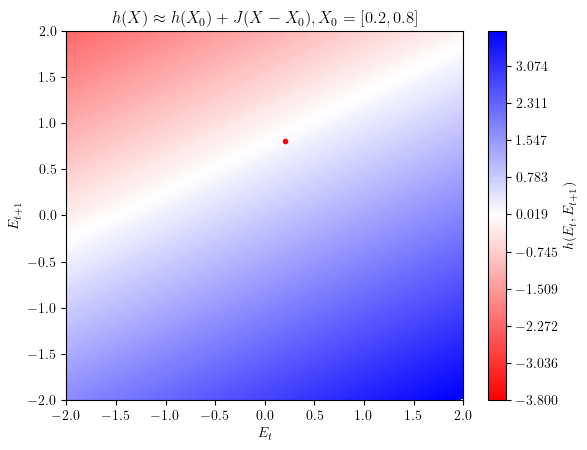

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import norm
import torch
from matplotlib.colors import LinearSegmentedColormap

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('animation', html='jshtml')

colours = [
    (0.0, 'red'),  
    (0.5, 'white'),
    (1.0, 'blue')  
]

cmap = LinearSegmentedColormap.from_list('RedWhiteBlue', colours)

k = 5
P = .2
tau_E = 1

lmbda_in = torch.tensor([[0.05 ** -2]])

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))
    
def _dedt(E):
    return (-E + sigmoid(k*E + k*P)) / tau_E

def meas_fn(Et, Etp):
    Etp, Et = torch.as_tensor(Etp), torch.as_tensor(Et)
    return torch.abs(Etp - (Et + _dedt(Et)))

Et, Etp = 0.2, 0.8
Et_values = torch.linspace(-2, 2, 1000)
Etp_values = torch.linspace(-2, 2, 1000)

Et_tensor = torch.tensor(Et, requires_grad=True)
Etp_tensor = torch.tensor(Etp, requires_grad=True)

X0 = torch.tensor((Et_tensor, Etp_tensor))
h_X0 = meas_fn(Et_tensor, Etp_tensor)
h_X0.backward()
J = torch.tensor([[Et_tensor.grad, Etp_tensor.grad]])
# print(h_X0, J)

print(f'Using {Et} and {Etp} to calculate...')

eta = J.T @ lmbda_in * ((J @ X0) - h_X0) 
lmbdap = J.T @ lmbda_in @ J

Et_grid, Etp_grid = torch.meshgrid(Et_values, Etp_values)

X_flat = torch.stack((Etp_grid.flatten(), Et_grid.flatten()), dim=1)

# print((X_flat - X0).shape)
h_approx_flat = h_X0 + J @ (X_flat - X0).T

meas_values = h_approx_flat.detach().view(Et_grid.shape).numpy()

plt.plot(Et, Etp, 'r.')
contour_levels = np.linspace(-3.8, 3.8, 200)
# # print(f'True Value: {meas_fn(0.2, 0.8)}, Approximated value: {h_approx(0.2, 0.8, 0.2, 0.8)}')
plt.contourf(Et_values, Etp_values, meas_values, levels=contour_levels, cmap=cmap)
plt.xlabel(r'$E_t$')
plt.ylabel(r'$E_{t+1}$')
plt.title(rf'$h(X) \approx h(X_0) + J(X - X_0), X_0 = [{Et}, {Etp}]$')
cbar = plt.colorbar()
cbar.set_label('$h(E_t, E_{t + 1}$)')

In [102]:
sigma = torch.linalg.inv(lmbdap)
mu = sigma @ eta

print(mu)
print(sigma)

tensor([[0.0000],
        [0.5000]], grad_fn=<MmBackward0>)
tensor([[95114.7500, 49932.1914],
        [49932.1914, 26212.8008]])


In [58]:
import torch
def select_not_i(tensor, i):
    '''
    Selects not the ith row and ith column from a tensor
    '''
    mask = torch.ones(tensor.shape[0], dtype=torch.bool)
    mask[i] = False
    return tensor[mask][:, mask]

tensor = torch.tensor([[1, 2, 3, 4],
                       [5, 6, 7, 8],
                       [9, 10, 11, 12],
                       [13, 14, 15, 16]])

i = 1
i_mask = torch.zeros(tensor.shape[0], dtype=torch.bool)
i_mask[i] = True

not_i_mask = torch.ones(tensor.shape[0], dtype=torch.bool)
not_i_mask[i] = False

# the ith row and NOT the ith col
tensor[i, not_i_mask] += torch.tensor([12,12,12])

eta = torch.tensor([1,2,3,4])

eta_i, eta_not_i = eta[i], eta[not_i_mask]
eta_i, eta_not_i

(tensor(2), tensor([1, 3, 4]))